In [1]:
import torch
import torch.nn as nn
from torch.utils.data import  Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import ast
import datetime as dt
import gc

C:\Users\y3g9r\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Обучение модели

In [2]:
class DisambiguationDataset(Dataset):
    def __init__(self, samples,labels):
        self.samples = samples
        self.labels = labels
        self.len = len(self.samples)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        items = {"text_input_ids": torch.tensor(self.samples[index][0]),
                 "text_input_mask": torch.tensor(self.samples[index][1]),
                 "text_segment_ids": torch.tensor(self.samples[index][2]),
                 "text_offset_mapping": torch.tensor(self.samples[index][3]),
                 "text_pos": torch.tensor(self.samples[index][4]),
                 "def_input_ids": torch.tensor(self.samples[index][5]),
                 "def_input_mask": torch.tensor(self.samples[index][6]),
                 "def_segment_ids": torch.tensor(self.samples[index][7]),
                 "label": torch.tensor(self.labels[index])}
        return items

In [3]:
class NerualNet(nn.Module):
    def __init__(self, hidden_size=768, max_seq_len=388, device='cpu'):
        self.device = device
        super(NerualNet, self).__init__()
        self.bert = BertModel.from_pretrained('sberbank-ai/sbert_large_mt_nlu_ru', output_hidden_states=True,
                                              return_dict=False)
        
        for layer in self.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = False
        

        self.text_linear_1 = torch.nn.Linear(1024, 512)
        self.def_linear_1 = torch.nn.Linear(1024, 512)


        self.text_linear_2 = torch.nn.Linear(512, 256)
        self.def_linear_2 = torch.nn.Linear(512, 256)
        
        self.sigm_linear_1 = torch.nn.Linear(256, 1)
        self.Dropout_sigm = torch.nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                text_pos, def_input_ids, def_input_mask, def_segment_ids):

        embd_batch = torch.tensor([[[], []]]).to(self.device)
        first_pass = False
        for i in range(len(text_input_ids)):
            # получаем эмбединги ключевого слова из примера употребления
            examples_token_key_word_position = self.token_detection(text_offset_mapping[i], text_pos[i][0])
            example_token_vec = self.get_vector(text_input_ids[i], text_segment_ids[i], text_input_mask[i])
            example_embeddings = self.vector_recognition(example_token_vec, examples_token_key_word_position)

            # получаем эмбединг определения
            def_embedding = self.get_defenition_embedding(def_input_ids[i], def_segment_ids[i],
                                                          def_input_mask[i]).squeeze(0)
            # объединяем два вектора в 1 и добавляем в общий массив (получаем тензор 2x768)
            embd_sample = torch.stack((example_embeddings, def_embedding)).to(self.device)
            if not first_pass:
                embd_batch = torch.cat((embd_batch, embd_sample.unsqueeze(0)), -1)
                first_pass = True
            else:
                embd_batch = torch.cat((embd_batch, embd_sample.unsqueeze(0)), 0)

                
        text_emb = embd_batch[:, 0, :]
        def_emb = embd_batch[:, 1, :]

        ex_emb =  self.text_linear_2(self.text_linear_1(text_emb))
        def_emb = self.def_linear_2(self.def_linear_1(def_emb))

        dist = torch.abs(ex_emb-def_emb)
        py = self.Dropout_sigm(self.sigm_linear_1(dist))

        y = self.sigmoid(py).permute(1,0).squeeze(0)

        return y

    def get_defenition_embedding(self, def_input_ids, def_segment_ids, def_input_mask):
        """
        Функция получения вектора дефенишина сущности
        :param def_input_ids:
        :param def_segment_ids:
        :param def_input_mask:
        :return: bert pooler output vector
        """
        with torch.no_grad():
            output = self.bert(input_ids=def_input_ids.unsqueeze(0), token_type_ids=def_segment_ids.unsqueeze(0),
                               attention_mask=def_input_mask.unsqueeze(0))
        hidden_states = output[1]
        return hidden_states

    def token_detection(self, token_map, position):
        """
        Функция определения ключевого слова
        :param token_map: list of tuples of begin and end of every token
        :param position:  list of type: [int,int]
        :return: list of key word tokens position
        """
        # из за того что в начале стоит CLS позиции начала и конца ключевого слова сдвигаются на 5
        begin_postion = position[0]  # + 5
        end_position = position[1]  # + 5

        position_of_key_tokens = []
        for token_tuple in range(1, len(token_map) - 1):
            # Если ключевое слово представляется одним токеном
            if token_map[token_tuple][0] == begin_postion and token_map[token_tuple][1] == end_position:
                position_of_key_tokens.append(token_tuple)
                break

            # Если ключевое слово представляется несколькими токенами
            if token_map[token_tuple][0] >= begin_postion and token_map[token_tuple][1] != end_position:
                position_of_key_tokens.append(token_tuple)
            if token_map[token_tuple][0] != begin_postion and token_map[token_tuple][1] == end_position:
                position_of_key_tokens.append(token_tuple)
                break

        return position_of_key_tokens

    def get_vector(self, input_ids_samp, token_type_ids_samp, attention_mask_samp):
        """
        Функция получения вектора ключевого слова
        :param input_ids_samp:
        :param token_type_ids_samp:
        :param attention_mask_samp:
        :return:
        """
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids_samp.unsqueeze(0), token_type_ids=token_type_ids_samp.unsqueeze(0),
                                attention_mask=attention_mask_samp.unsqueeze(0))
        hidden_states = outputs[2]

        # из [# layers, # batches, # tokens, # features]
        # в [# tokens, # layers, # features]
        token_dim = torch.stack(hidden_states, dim=0)
        token_dim = torch.squeeze(token_dim, dim=1)
        token_dim = token_dim.permute(1, 0, 2)
        token_vecs_cat = []
        for token in token_dim:
            cat_vec = torch.sum(token[-4:], dim=0)
            token_vecs_cat.append(cat_vec)
        return token_vecs_cat


    def vector_recognition(self, tokens_embeddings_ex, tokens_key_word_position_ex):
        """
        Функция подготовки вектора в зависимости от количества токенов,которым представляется ключевое слово
        :param tokens_embeddings_ex:
        :param tokens_key_word_position_ex:
        :return:
        """
        if len(tokens_key_word_position_ex) > 1:
            embeddings_data = torch.tensor(
                self.__get_avarage_embedding(tokens_embeddings_ex, tokens_key_word_position_ex))
        else:
            embeddings_data = torch.tensor(tokens_embeddings_ex[tokens_key_word_position_ex[0]])
        return embeddings_data

    def __get_avarage_embedding(self, embeddings_list, positions_list):
        """
        Функция получения среднего вектора (применяется в случае если ключевое слово состоит из нескольких токенов)
        :param embeddings_list:
        :param positions_list:
        :return:
        """
        avg_tensor = torch.stack((embeddings_list[positions_list[0]],))
        for i in range(1, len(positions_list)):
            avg_tensor = torch.cat((avg_tensor, embeddings_list[positions_list[i]].unsqueeze(0)))

        average_embedding = torch.mean(avg_tensor, 0)
        return average_embedding

In [4]:
class Trainer():
    def __init__(self, num_epochs=None, batch_size=None,
                 max_batches_per_epoch=None, early_stopping=10,
                 loss_fn=None, optimizer=None, model=None,
                 scheduler=None, device='cpu'):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.early_stopping = early_stopping
        self.loss_fn = loss_fn
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.start_model = model
        self.best_model = model

        self.train_loss = []
        self.valid_loss = []

    def predict(self, input_ids, input_mask, segment_ids):
        return self.best_model(input_ids, input_mask, segment_ids)

    def save_model(self, path: str):
        try:
            torch.save(self.best_model, path)
        except Exception as e:
            print(f"Не удалось сохранить модель. Ошибка {e}")
            exit(1)

        return True

    def load_model(self, path: str):
        try:
            self.best_model.load_state_dict(torch.load(path))
        except Exception as e:
            print(f"Не удалось загрузить модель. Ошибка {e}")
            exit(1)

        return True

    def fit(self, train_dataset, valid_dataset):
        device = torch.device(self.device)
        NerualNet = self.start_model
        NerualNet.to(device)

        NerualNet.train()

        self.optimizer = optim.Adam(NerualNet.parameters(), lr=0.0001)

        train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size,
                                  shuffle=False, drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.batch_size,
                                  shuffle=False, drop_last=True)

        best_val_loss = float('inf')  # Лучшее значение функции потерь на валидационной выборке

        best_ep = 0  # Эпоха, на которой достигалось лучшее значение функции потерь на валидационной выборке

        for epoch in range(self.num_epochs):
            start = dt.datetime.now()
            mean_loss = 0
            batch_n = 0
            for batch in train_loader:
                y_truth = batch["label"].float().to(device)
                text_input_ids = batch["text_input_ids"].to(device)
                text_input_mask = batch["text_input_mask"].to(device)
                text_segment_ids = batch["text_segment_ids"].to(device)
                text_offset_mapping = batch["text_offset_mapping"].to(device)
                text_pos = batch["text_pos"].to(device)
                def_input_ids = batch["def_input_ids"].to(device)
                def_input_mask = batch["def_input_mask"].to(device)
                def_segment_ids = batch["def_segment_ids"].to(device)
                y_pred = NerualNet(text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                                   text_pos, def_input_ids, def_input_mask, def_segment_ids).float()
  
                loss = self.loss_fn(y_pred, y_truth)
                #loss.requires_grad = True
        
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                del batch
                torch.cuda.empty_cache()
                gc.collect()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Эпоха: {epoch + 1}\n Train loss: {mean_loss}\n {dt.datetime.now() - start} сек.\n')

            NerualNet.eval()
            mean_loss = 0
            batch_n = 0
            with torch.no_grad():
                for batch in valid_loader:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break

                target = batch["label"].float().to(device)
                text_input_ids = batch["text_input_ids"].to(device)
                text_input_mask = batch["text_input_mask"].to(device)
                text_segment_ids = batch["text_segment_ids"].to(device)
                text_offset_mapping = batch["text_offset_mapping"].to(device)
                text_pos = batch["text_pos"].to(device)
                def_input_ids = batch["def_input_ids"].to(device)
                def_input_mask = batch["def_input_mask"].to(device)
                def_segment_ids = batch["def_segment_ids"].to(device)

                predicted_values = NerualNet(text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                                             text_pos, def_input_ids, def_input_mask, def_segment_ids).float()
                
                
                loss = self.loss_fn(predicted_values, target)

                del batch
                torch.cuda.empty_cache()
                gc.collect()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.valid_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = NerualNet
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

        print("-=-=-=-=-=-=-=-=-=-= Evaluation of the best model =-=-=-=-=-=-=-=-=-=-")
        plt.plot(range(len(self.train_loss)), self.train_loss, color='green', label='train', linestyle='solid')
        plt.plot(range(len(self.valid_loss)), self.valid_loss, color='red', label='val', linestyle='solid')
        plt.legend()
        plt.show()

        with torch.no_grad():
            y_test = [float(sample['label']) for sample in valid_dataset]
            Y_pred = []
            Y_pred = [self.best_model(sample['text_input_ids'].unsqueeze(0).to(device), 
                                      sample['text_input_mask'].unsqueeze(0).to(device),
                                      sample['text_segment_ids'].unsqueeze(0).to(device),
                                      sample['text_offset_mapping'].unsqueeze(0).to(device),
                                      sample['text_pos'].unsqueeze(0).to(device),
                                      sample['def_input_ids'].unsqueeze(0).to(device),
                                      sample['def_input_mask'].unsqueeze(0).to(device),
                                      sample['def_segment_ids'].unsqueeze(0).to(device)) for sample in valid_dataset]
            Y_pred = [float(y > 0.5) for y in Y_pred]
            print()

            print(f"report: \n", classification_report(y_test, Y_pred))

In [5]:
def data_preparation(texts, definitions, position, labels, tokenizer, max_len):
    tokenizer = tokenizer
    feautures_X, feautures_Y = [], []

    for i, (text, definition) in enumerate(zip(texts, definitions)):
        text = tokenizer(text, return_offsets_mapping=True,max_length=max_len,truncation=True,padding='max_length')

        text_input_ids = text["input_ids"]
        text_input_mask = text["attention_mask"]
        text_segment_ids = text["token_type_ids"]
        text_offset_mapping = text["offset_mapping"]
        text_pos = [position[i]]

        definition = tokenizer(definition, return_offsets_mapping=True,max_length=max_len,padding='max_length',truncation=True)

        def_input_ids = definition["input_ids"]
        def_input_mask = definition["attention_mask"]
        def_segment_ids = definition["token_type_ids"]

        feautures_X.append([text_input_ids, text_input_mask, text_segment_ids, text_offset_mapping,
                            text_pos, def_input_ids, def_input_mask, def_segment_ids])
        feautures_Y.append(labels[i])

    return feautures_X, feautures_Y

In [6]:
torch.cuda.empty_cache()
gc.collect()

0

C:\Users\y3g9r\AppData\Local\Temp\ipykernel_1744\1371837674.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_data = torch.tensor(tokens_embeddings_ex[tokens_key_word_position_ex[0]])
C:\Users\y3g9r\AppData\Local\Temp\ipykernel_1744\1371837674.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_data = torch.tensor(


Эпоха: 1
 Train loss: 0.7584154632958499
 0:05:12.804053 сек.

Loss_val: 0.6529518365859985

Эпоха: 2
 Train loss: 0.6361601457300813
 0:04:59.830936 сек.

Loss_val: 0.37530913949012756

Эпоха: 3
 Train loss: 0.5521529889618507
 0:04:52.217871 сек.

Loss_val: 0.23524387180805206

Эпоха: 4
 Train loss: 0.4882840225943411
 0:04:50.517283 сек.

Loss_val: 0.2108456939458847

Эпоха: 5
 Train loss: 0.44088493660092354
 0:04:50.316020 сек.

Loss_val: 0.16641929745674133

Эпоха: 6
 Train loss: 0.3959428071975708
 0:04:50.504324 сек.

Loss_val: 0.15737178921699524

Эпоха: 7
 Train loss: 0.35465240869859255
 0:04:50.373486 сек.

Loss_val: 0.16241909563541412

Эпоха: 8
 Train loss: 0.31798608572871395
 0:04:50.439124 сек.

Loss_val: 0.1306658387184143

Эпоха: 9
 Train loss: 0.2828061860431023
 0:04:50.314272 сек.

Loss_val: 0.104605533182621

Эпоха: 10
 Train loss: 0.2564711815047294
 0:04:56.295978 сек.

Loss_val: 0.07215018570423126

Эпоха: 11
 Train loss: 0.23199556592024034
 0:05:03.203213 се

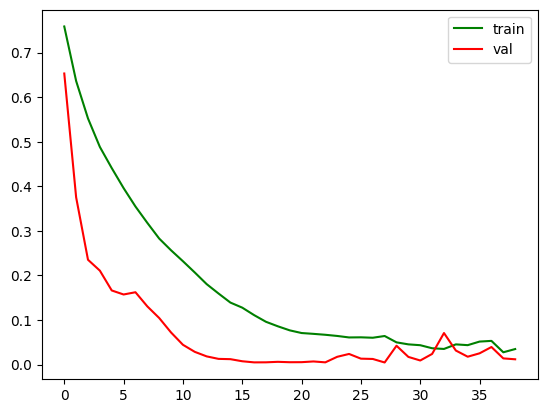


report: 
               precision    recall  f1-score   support

         0.0       0.69      0.77      0.73       106
         1.0       0.70      0.60      0.64        92

    accuracy                           0.69       198
   macro avg       0.69      0.69      0.69       198
weighted avg       0.69      0.69      0.69       198



In [7]:



df = pd.read_csv('./../../nn_data.csv')
df.position = df.position.apply(lambda x: ast.literal_eval(x))

max_len_text = df.text.str.len().max()
max_len_def = df.definition.str.len().max()

max_len = max_len_def
if max_len_text > max_len_def:
    max_len = max_len_text

data_X, data_Y = data_preparation(df.text,
                                  df.definition,
                                  df.position,
                                  df.label,
                                  BertTokenizerFast.from_pretrained('sberbank-ai/sbert_large_mt_nlu_ru',
                                                                do_lower_case=True),
                                  max_len)

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.2, random_state=42)

train_dataset = DisambiguationDataset(train_X, train_Y)
test_dataset = DisambiguationDataset(test_X, test_Y)

trainer = Trainer(num_epochs=40,
                  batch_size=4,
                  loss_fn=nn.BCELoss(),
                  model=NerualNet(max_seq_len=max_len, device='cuda:0'),
                  device='cuda:0')

trainer.fit(train_dataset=train_dataset, valid_dataset=test_dataset)

In [8]:
torch.save(trainer.best_model.state_dict(), "./modelN.pth")